### **Cloud Data Engineering Module by Qasim Hassan**

#### A basice Extract, Transform and Load (ETL) pipeline using web scrapping, pandas and sql
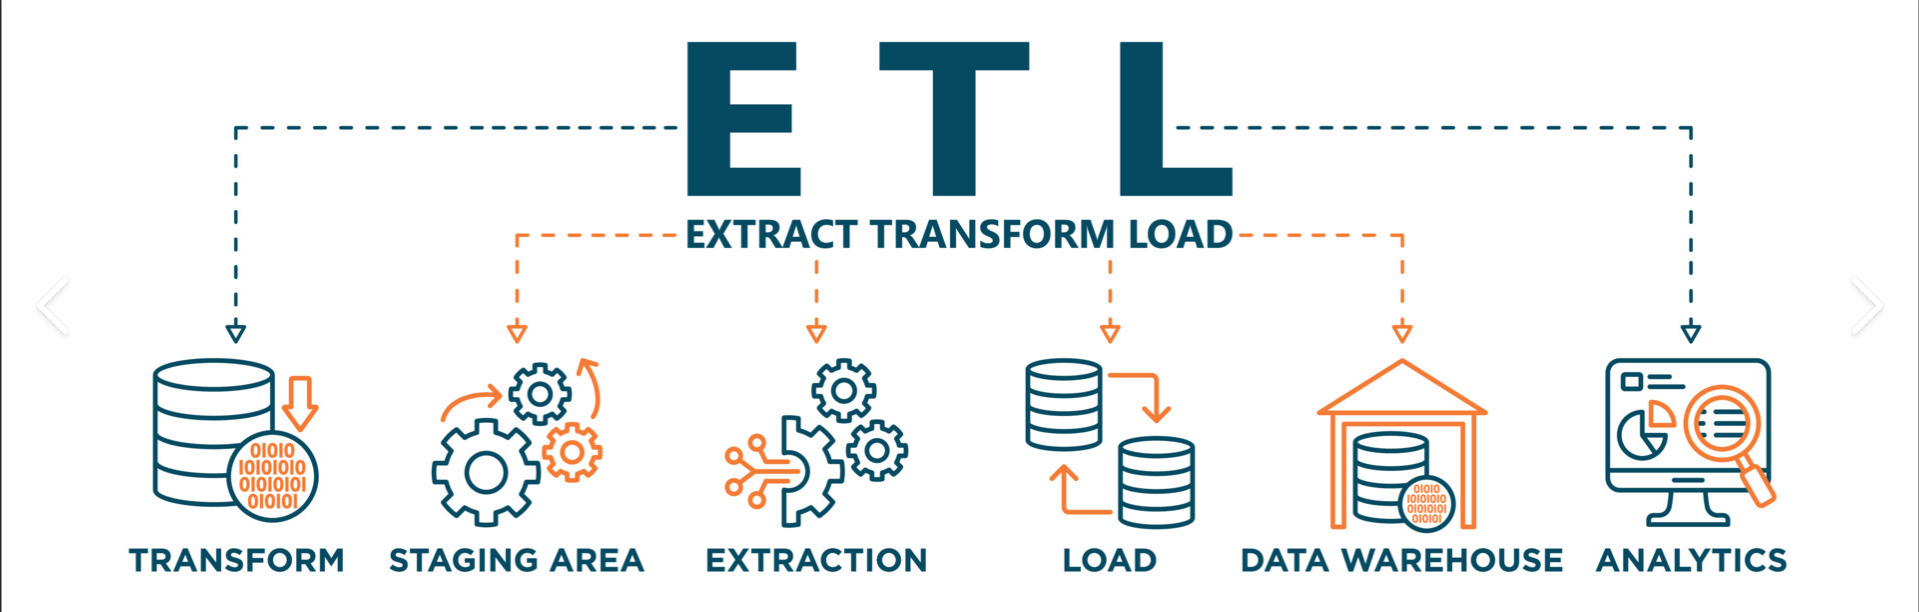

#### Import necessary Libraries

In [1]:
from io import StringIO
import requests
from bs4 import BeautifulSoup
import pandas as pd
import sqlite3
from datetime import datetime
# from icecream import ic

#### Step 0: Maintaining a Log File
This step is done to record the logs while performing ETL and it is not neccessary in an ETL Pipeline

In [2]:
def log_progress(message):
    """This function logs the mentioned message of a given stage of the
    code execution to a log file. Function returns nothing"""

    with open('./logs/code_log.txt', 'a') as f:
        f.write(f'{datetime.now()}: {message}\n')

#### Step 1: Extract

In [3]:
def extract(url, table_attribs):
    """ This function aims to extract the required
    information from the website and save it to a data frame. The
    function returns the data frame for further processing. """

    soup = BeautifulSoup(requests.get(url).text, 'html.parser')
    table = soup.find('span', string=table_attribs).find_next('table')
    df = pd.read_html(StringIO(str(table)))[0]

    log_progress('Data extraction complete. Initiating Transformation process')

    return df

#### Step 2: Transform

In [4]:
def transform(df, csv_path):
    """ This function accesses the CSV file for exchange rate
    information, and adds three columns to the data frame, each
    containing the transformed version of Market Cap column to
    respective currencies"""

    exchange_rate = pd.read_csv(csv_path, index_col=0).to_dict()['Rate']

    df['MC_GBP_Billion'] = round(df['Market cap (US$ billion)'] * exchange_rate['GBP'], 2)
    df['MC_EUR_Billion'] = round(df['Market cap (US$ billion)'] * exchange_rate['EUR'], 2)
    df['MC_INR_Billion'] = round(df['Market cap (US$ billion)'] * exchange_rate['INR'], 2)

    print(df)

    log_progress('Data transformation complete. Initiating Loading process')

    return df

#### Step 3: Load

Loading data to a CSV

In [5]:
def load_to_csv(df, output_path):
    """ This function saves the final data frame as a CSV file in
    the provided path. Function returns nothing."""

    df.to_csv(output_path)

    log_progress('Data saved to CSV file')

Loading data to SQL

In [6]:
def load_to_db(df, sql_connection, table_name):
    """ This function saves the final data frame to a database
    table with the provided name. Function returns nothing."""

    df.to_sql(table_name, sql_connection, if_exists='replace', index=False)

    log_progress('Data loaded to Database as a table, Executing queries')

In [7]:
def run_query(query_statement, sql_connection):
    """ This function runs the query on the database table and
    prints the output on the terminal. Function returns nothing. """

    cursor = sql_connection.cursor()
    cursor.execute(query_statement)
    result = cursor.fetchall()

    log_progress('Process Complete')

    return result

print("+++++++++  Exchange Rate  +++++++++++++")
transform1=pd.read_csv('./input/exchange_rate.csv')
transform1

### Executing Pipeline

In [12]:
if __name__ == '__main__':
    url = 'https://web.archive.org/web/20230908091635/https://en.wikipedia.org/wiki/List_of_largest_banks'
    output_csv_path = './output/Largest_banks_data.csv'
    database_name = './output/Banks.db'
    table_name = 'Largest_banks'
    log_progress('Preliminaries complete. Initiating ETL process')

    df = extract(url, 'By market capitalization')

    transform(df, './input/exchange_rate.csv')

    load_to_csv(df, output_csv_path)

    with sqlite3.connect(database_name) as conn:
        load_to_db(df, conn, table_name)

        print(run_query('SELECT * FROM Largest_banks', conn))
        print("++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++")
        print(run_query('SELECT AVG(MC_GBP_Billion) FROM Largest_banks', conn))
        print("++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++")
        print(run_query('SELECT "Bank name" FROM Largest_banks LIMIT 5', conn))

   Rank                                Bank name  Market cap (US$ billion)  \
0     1                           JPMorgan Chase                    432.92   
1     2                          Bank of America                    231.52   
2     3  Industrial and Commercial Bank of China                    194.56   
3     4               Agricultural Bank of China                    160.68   
4     5                                HDFC Bank                    157.91   
5     6                              Wells Fargo                    155.87   
6     7                        HSBC Holdings PLC                    148.90   
7     8                           Morgan Stanley                    140.83   
8     9                  China Construction Bank                    139.82   
9    10                            Bank of China                    136.81   

   MC_GBP_Billion  MC_EUR_Billion  MC_INR_Billion  
0          346.34          419.93        36798.20  
1          185.22          224.57    

In [13]:
df=pd.read_csv('./output/Largest_banks_data.csv')
df

,Unnamed: 0,Rank,Bank name,Market cap (US$ billion),MC_GBP_Billion,MC_EUR_Billion,MC_INR_Billion
0,0,1,JPMorgan Chase,432.92,346.34,419.93,36798.20
1,1,2,Bank of America,231.52,185.22,224.57,19679.20
2,2,3,Industrial and Commercial Bank of China,194.56,155.65,188.72,16537.60
3,3,4,Agricultural Bank of China,160.68,128.54,155.86,13657.80
4,4,5,HDFC Bank,157.91,126.33,153.17,13422.35
5,5,6,Wells Fargo,155.87,124.70,151.19,13248.95
6,6,7,HSBC Holdings PLC,148.90,119.12,144.43,12656.50
7,7,8,Morgan Stanley,140.83,112.66,136.61,11970.55
8,8,9,China Construction Bank,139.82,111.86,135.63,11884.70
9,9,10,Bank of China,136.81,109.45,132.71,11628.85


In [14]:
def print_text_file(file_path):
    try:
        with open(file_path, 'r') as file:
            print("Text File Contents:")
            print(file.read())
    except FileNotFoundError:
        print(f"File not found: {file_path}")
# Example usage
print_text_file('./logs/code_log.txt')  



Text File Contents:
2025-02-01 12:28:54.417875: Preliminaries complete. Initiating ETL process
2025-02-01 12:28:55.717771: Data extraction complete. Initiating Transformation process
2025-02-01 12:28:55.717771: Data transformation complete. Initiating Loading process
2025-02-01 12:28:55.733235: Data saved to CSV file
2025-02-01 12:28:55.750870: Data loaded to Database as a table, Executing queries
2025-02-01 12:28:55.750870: Process Complete
2025-02-01 12:28:55.750870: Process Complete
2025-02-01 12:28:55.750870: Process Complete

